In [ ]:
!pip install timesfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of googleapis-common-protos to determine which version is compatible with other requirements. This could take a while.
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.2/440.2 kB 25.1 MB/s et

In [ ]:
import timesfm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

2024-09-11 15:11:35.154827: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64


In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/marcopeix/FoundationModelsForTimeSeriesForecasting/main/data/walmart_sales_small.csv")
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


In [ ]:
tfm = timesfm.TimesFm(
    context_len=128,
    horizon_len=8,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend='cpu' #cuda for GPU backend
)

tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 5.92 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 10.10 seconds.
Jitting decoding.
Jitted decoding in 48.73 seconds.


In [ ]:
df = df.rename(columns={"Store": "unique_id", "Date": "ds"})
df['ds'] = pd.to_datetime(df['ds'])
df.head()

,unique_id,ds,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


In [ ]:
preds_df = tfm.forecast_on_df(
    inputs=df,
    freq="W",
    value_name="Weekly_Sales",
    num_jobs=-1
)

Processing dataframe with multiple processes.


2024-09-11 15:07:10.666087: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-09-11 15:07:10.666741: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64


Finished preprocessing dataframe.
Finished forecasting.


In [ ]:
preds_df.head()

,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,1,2012-10-28,1558211.375,1424910.625,1470472.875,1498815.375,1521003.125,1558211.375,1580770.625,1623610.500,1670535.875,1740275.875
1,1,2012-11-04,1643644.125,1496657.875,1543861.250,1582917.625,1612650.125,1643644.125,1677166.625,1721966.750,1773816.875,1860391.000
2,1,2012-11-11,1675617.750,1518079.875,1574793.875,1605005.375,1638169.375,1675617.750,1714717.250,1760203.875,1817430.750,1901821.000
3,1,2012-11-18,1678629.375,1505856.875,1559485.000,1604470.000,1637809.375,1678629.375,1710017.000,1761639.000,1818151.250,1919740.250
4,1,2012-11-25,1720319.625,1525662.375,1579210.250,1634411.875,1669417.500,1720319.625,1758985.875,1806930.625,1872009.875,1973372.250


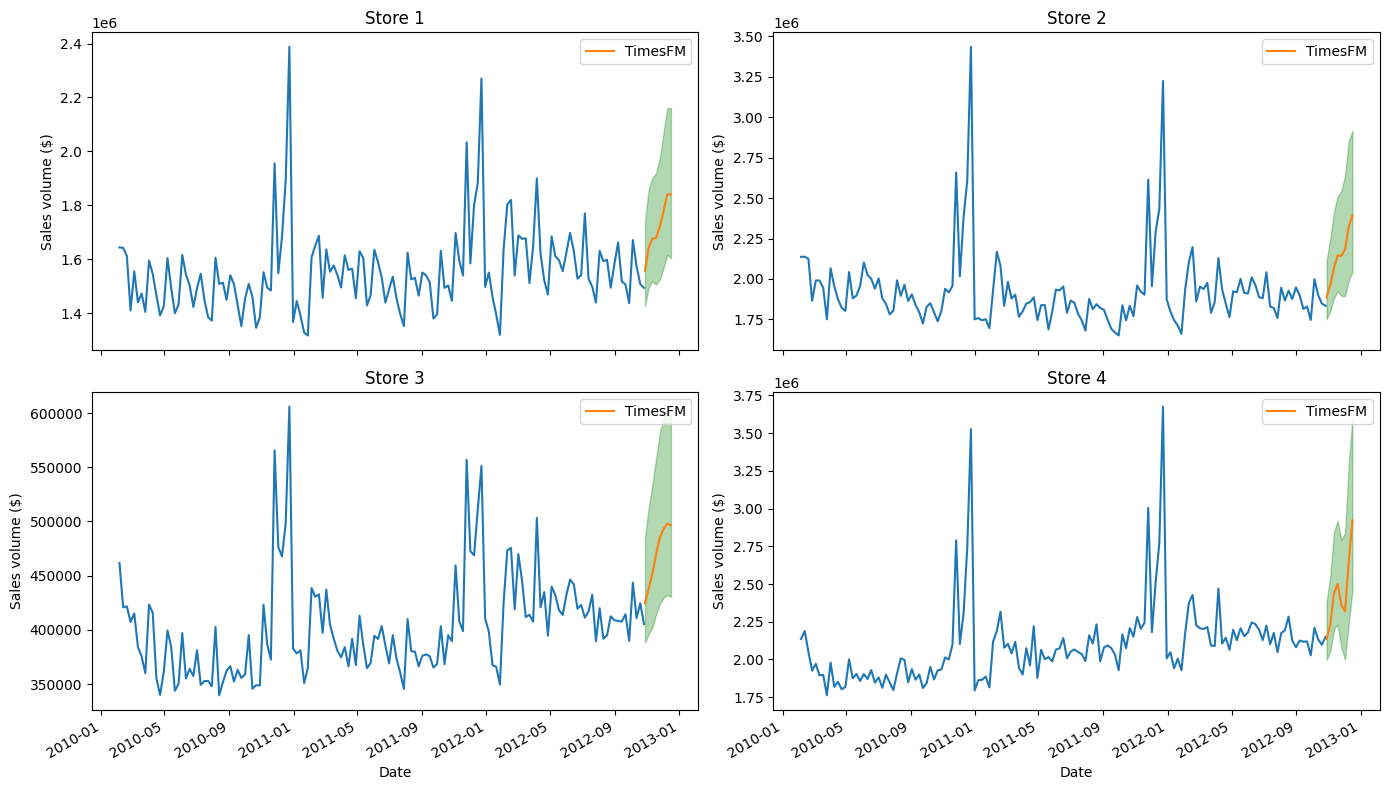

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))

for i, ax in enumerate(axes.flatten()):
    store_id = i+1
    data = df.query("unique_id == @store_id")
    preds = preds_df.query("unique_id == @store_id")

    ax.plot(data['ds'], data['Weekly_Sales'])
    ax.plot(preds['ds'], preds['timesfm'], label='TimesFM')
    ax.fill_between(preds['ds'], preds['timesfm-q-0.1'], preds['timesfm-q-0.9'], color="green", alpha=0.3)

    ax.set_title(f"Store {store_id}")
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales volume ($)')
    ax.legend(loc=1)

fig.autofmt_xdate()
plt.tight_layout()

## Cross-validation with TimesFM

In [ ]:
def cross_validation_timesfm(df, h, n_windows, target_col, freq):
  all_preds = []

  for i in range(n_windows, 0, -1):
    input_df = df.iloc[:-(h*i)]

    preds_df = tfm.forecast_on_df(
    inputs=input_df,
    freq=freq,
    value_name=target_col,
    num_jobs=-1
    )

    all_preds.append(preds_df)

  preds = pd.concat(all_preds, axis=0, ignore_index=True)

  return preds

In [ ]:
cv_df = df.query("unique_id == 1")

In [ ]:
cv_preds = cross_validation_timesfm(
    df=cv_df,
    h=8,
    n_windows=4,
    target_col="Weekly_Sales",
    freq="W")

cv_preds.head()

Processing dataframe with multiple processes.


2024-09-11 15:07:39.723148: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


2024-09-11 15:07:55.991110: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


2024-09-11 15:08:12.544351: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


2024-09-11 15:08:29.117159: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64


Finished preprocessing dataframe.
Finished forecasting.


,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,1,2012-03-18,1605790.875,1454378.250,1504710.125,1540406.25,1576147.750,1605790.875,1633066.250,1672422.875,1717975.000,1786371.375
1,1,2012-03-25,1594497.125,1435897.375,1490014.875,1526411.00,1562529.875,1594497.125,1626155.750,1665629.750,1717719.125,1793620.875
2,1,2012-04-01,1595431.000,1434976.000,1487808.750,1527801.75,1562524.000,1595431.000,1629223.125,1674874.125,1724769.000,1807854.875
3,1,2012-04-08,1607208.750,1439314.250,1490966.625,1532729.00,1564144.250,1607208.750,1640608.750,1684934.750,1731571.375,1820970.875
4,1,2012-04-15,1569982.750,1410785.750,1462000.000,1498719.50,1537677.875,1569982.750,1608486.625,1647902.625,1702313.500,1782570.125


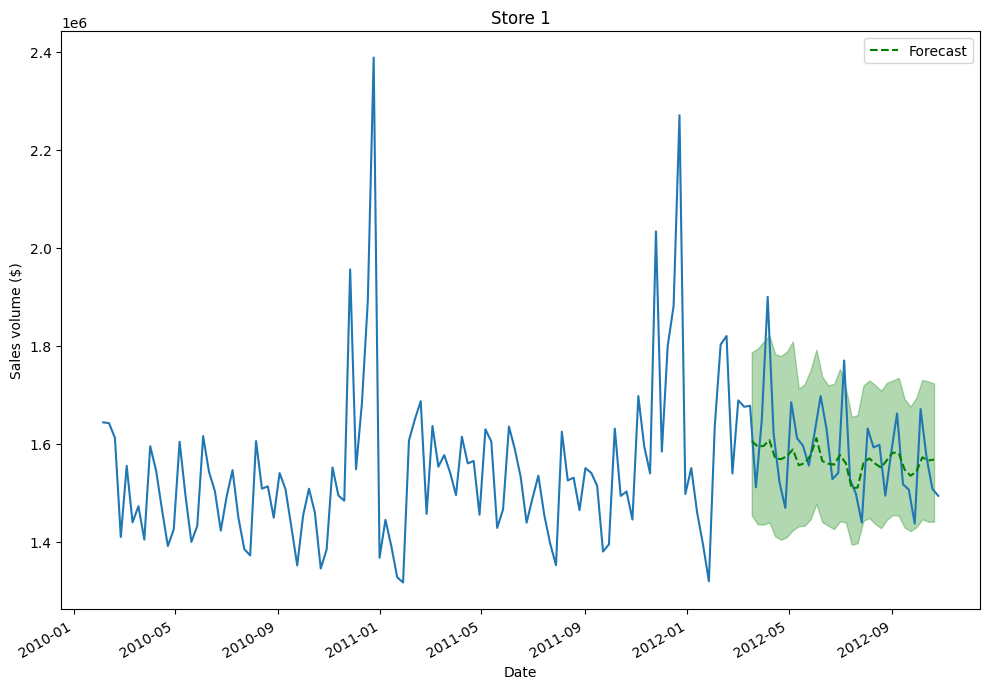

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(cv_df['ds'], cv_df['Weekly_Sales'])
ax.plot(cv_preds['ds'], cv_preds['timesfm'], ls='--', color='green', label='Forecast')
ax.fill_between(cv_preds['ds'], cv_preds['timesfm-q-0.1'], cv_preds['timesfm-q-0.9'], color="green", alpha=0.3)

ax.set_title(f"Store 1")
ax.set_xlabel('Date')
ax.set_ylabel('Sales volume ($)')
ax.legend(loc=1)

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
eval_df = cv_preds[['unique_id', 'ds', 'timesfm']]
eval_df['Weekly_Sales'] = cv_df['Weekly_Sales'][-32:].values

In [ ]:
from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate

evaluation = evaluate(
    eval_df,
    metrics=[mae, smape],
    models=['timesfm'],
    target_col='Weekly_Sales',
    id_col='unique_id'
)

evaluation

,unique_id,metric,timesfm
0,1,mae,65515.613750
1,1,smape,0.020474


## Forecasting with covariates

143

In [ ]:
train = cv_df[:-32]
test = cv_df[-32:]

train.head()

,unique_id,ds,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


In [ ]:
from collections import defaultdict

# Data pipelining
def get_batched_data_fn(
    batch_size: int = 2,
    context_len: int = 64,
    horizon_len: int = 32,
):
    examples = defaultdict(list)

    num_examples = 0
    for start in range(0, len(cv_df) - (context_len + horizon_len), horizon_len):
        num_examples += 1
        examples["inputs"].append(train["Weekly_Sales"][start:(context_end := start + context_len)].tolist())
        examples["Holiday_Flag"].append(train["Holiday_Flag"][start:context_end + horizon_len].tolist())
        examples["outputs"].append(train["Weekly_Sales"][context_end:(context_end + horizon_len)].tolist())

    def data_fn():
        for i in range(1 + (num_examples - 1) // batch_size):
            yield {k: v[(i * batch_size) : ((i + 1) * batch_size)] for k, v in examples.items()}

    return data_fn

In [ ]:
tfm_h32 = timesfm.TimesFm(
    context_len=64,
    horizon_len=32,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend='cpu'
)

tfm_h32.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

Multiprocessing context has already been set.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 4.74 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 6.32 seconds.
Jitting decoding.
Jitted decoding in 44.99 seconds.


In [ ]:
input_data = get_batched_data_fn()

for i, example in enumerate(input_data()):
    cov_forecast, _ = tfm_h32.forecast_with_covariates(
        inputs=example["inputs"],
        dynamic_numerical_covariates={},
        dynamic_categorical_covariates={
            "Holiday_Flag": example["Holiday_Flag"],
        },
        static_numerical_covariates={},
        static_categorical_covariates={},
        freq=[0] * len(example["inputs"]),
        xreg_mode="xreg + timesfm",
        ridge=0.0,
        force_on_cpu=False,
        normalize_xreg_target_per_input=True,
    )
    print(f"Done with round {i}")

Done with round 0


In [ ]:
cov_forecast[0]

array([1558848. , 1564170.1, 1567857.4, 1567619. , 1564836. , 1554741.1,
       1542824.5, 1529334.8, 1518207.9, 1509251.9, 1506431. , 1510052. ,
       1517274.9, 1517981.4, 1522438.5, 1526975.6, 1527395.8, 1529564.1,
       1530315.8, 1669588. , 1533426.5, 1536260.1, 1539858. , 1542444.6,
       1550574.9, 1557960.5, 1559142. , 1559711.8, 1553155.5, 1543093.6,
       1669204. , 1520270.1], dtype=float32)

In [ ]:
no_cov_preds = tfm_h32.forecast_on_df(
    inputs=train,
    freq="W",
    value_name="Weekly_Sales",
    num_jobs=-1
)

no_cov_preds.head()

Processing dataframe with multiple processes.


2024-09-11 15:32:07.699467: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64


Finished preprocessing dataframe.
Finished forecasting.


,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,1,2012-03-18,1628873.000,1461920.250,1517533.125,1558511.000,1593574.625,1628873.000,1659186.500,1700495.750,1748864.250,1824186.500
1,1,2012-03-25,1619620.250,1446132.875,1504663.750,1545307.500,1583704.500,1619620.250,1654400.125,1694664.750,1748335.375,1830591.625
2,1,2012-04-01,1619484.125,1444126.375,1502129.500,1546427.875,1584158.250,1619484.125,1656439.375,1700401.000,1751837.000,1839094.125
3,1,2012-04-08,1615534.750,1438196.875,1495148.125,1540254.375,1576919.375,1615534.750,1655306.750,1697043.125,1749196.750,1837891.875
4,1,2012-04-15,1607998.750,1429399.750,1484463.625,1530697.750,1571815.375,1607998.750,1651697.500,1689135.625,1748919.000,1837729.125


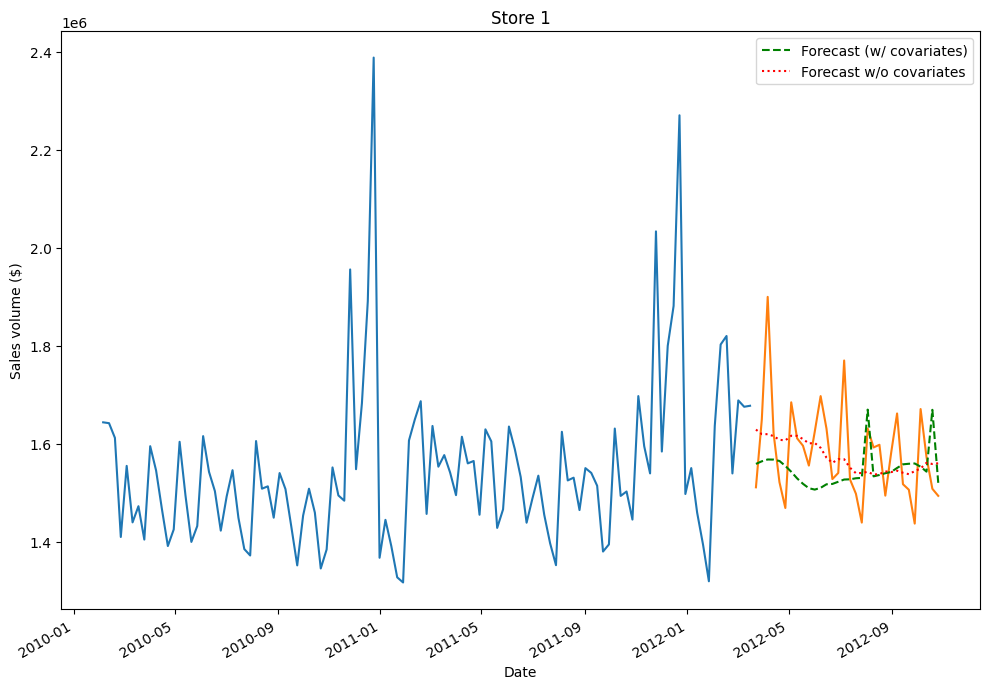

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(train['ds'], train['Weekly_Sales'])
ax.plot(test['ds'], test['Weekly_Sales'])
ax.plot(test['ds'], cov_forecast[0], ls='--', color='green', label='Forecast (w/ covariates)')
ax.plot(test['ds'], no_cov_preds['timesfm'], ls=':', color='red', label='Forecast w/o covariates')

ax.set_title(f"Store 1")
ax.set_xlabel('Date')
ax.set_ylabel('Sales volume ($)')
ax.legend(loc=1)

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate

eval_df = test[['unique_id', 'ds', 'Weekly_Sales']]
eval_df['timesfm_cov'] = cov_forecast[0]
eval_df['timesfm'] = no_cov_preds['timesfm'].values

evaluation = evaluate(
    eval_df,
    metrics=[mae, smape],
    models=['timesfm', 'timesfm_cov'],
    target_col='Weekly_Sales',
    id_col='unique_id'
)

evaluation

,unique_id,metric,timesfm,timesfm_cov
0,1,mae,69682.056250,84827.922187
1,1,smape,0.021829,0.026646
